In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.io import read_image
#from torchvision import transforms
import torchvision.transforms as T
# libreria para adquisición de imágenes
from google_images_download import google_images_download

In [ ]:
# Cargar imágenes

response = google_images_download.googleimagesdownload()
arguments_bogota = {'keywords': 'city street', 'suffix_keywords': 'bogota,-bogota' ,'limit':5,'output_directory':'Imagenes',"print_urls":True}

paths = response.download(arguments_bogota)
print(paths) 

In [2]:
p = T.Compose([T.Resize((183,183))])

In [3]:
x1 = p(read_image("Imagenes/city street bogota/Bog1.jpg"))
x2 = p(read_image("Imagenes/city street bogota/Bog2.jpg"))
x3 = p(read_image("Imagenes/city street bogota/Bog3.jpg"))
x4 = p(read_image("Imagenes/city street bogota/Bog4.jpg"))
x5 = p(read_image("Imagenes/city street bogota/Bog5.jpg"))
x6 = p(read_image("Imagenes/city street bogota/notBog1.jpg"))
x7 = p(read_image("Imagenes/city street bogota/notBog2.jpg"))
x8 = p(read_image("Imagenes/city street bogota/notBog3.jpg"))
x9 = p(read_image("Imagenes/city street bogota/notBog4.jpg"))
x10 = p(read_image("Imagenes/city street bogota/notBog5.jpg"))
x11 = p(read_image("Imagenes/city street bogota/notBog6.jpg"))
x12 = p(read_image("Imagenes/city street bogota/notBog7.jpg"))
x13 = p(read_image("Imagenes/city street bogota/notBog8.jpg"))
x14 = p(read_image("Imagenes/city street bogota/notBog9.jpg"))
type(x1)

torch.Tensor

In [4]:
X = np.zeros([14,3,183,183])

Z = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14]
for i in range(14):
    X[i,:] = Z[i]
Y = np.array([1.,1.,1.,1.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.])

In [48]:
# Separar los datos entre entrenamiento y testeo
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
X_train.shape

(10, 3, 183, 183)

In [49]:
model = torch.nn.Sequential(
  torch.nn.Conv2d(3, 16, kernel_size=2, stride=1, padding=2),
  # ( (183-2+2*2)/1 ) + 1 = 186   -> 186*186*16

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 186/2 = 93                 -> 93*93*16

  torch.nn.Dropout(p=0.2),

  torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
  # ( (93-3+2*2)/1 ) + 1 = 95   -> 95*95*32

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 95/2 = 47                 -> 47*47*32

  #torch.nn.Dropout(p=0.2), 

  torch.nn.Flatten(),
  torch.nn.Linear(47*47*32, 2)
)
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=70688, out_features=2, bias=True)
)

In [50]:
#-- Después de activar el entorno GPU se selecciona el dispositivo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [51]:
#--- Definimos los criterios de evaluación y el optmizador

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

In [52]:
#--- Visualizamos la estructura de nuestra CNN

import hiddenlayer as hl


#hl.build_graph(model, torch.zeros([16,3,183,183]))

In [53]:
batch_size = 32

train_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).long())
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

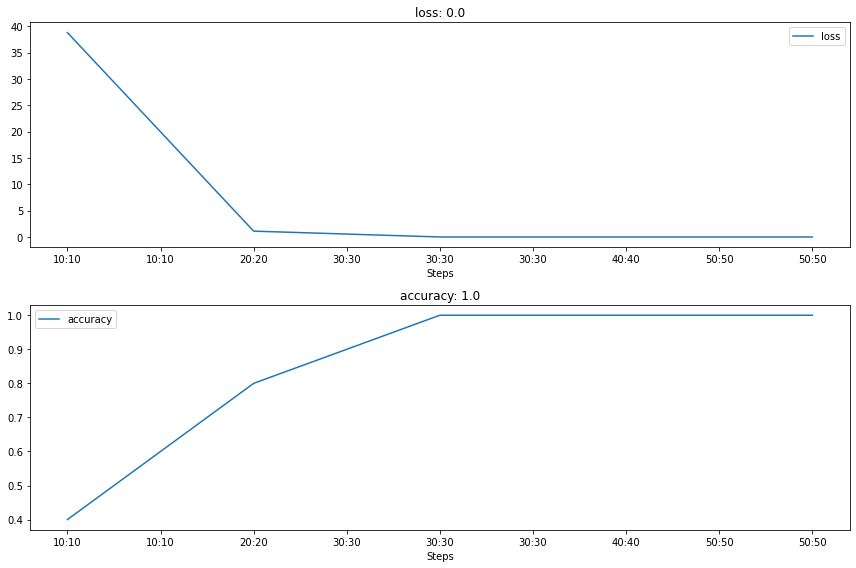

In [54]:
#--- Entrenamos la CNN

from sklearn.metrics import f1_score

n_epoch = 50

history = hl.History()
canvas = hl.Canvas()

model.to(device)
savacc = []
savef1 = []

i = 0

for epoch in range(n_epoch):
    for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

        #-- Cargamos los datos en la GPU
        X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

        model.train()
        Xtr = X_train_batch
        Y_pred = model(Xtr)

        loss = criterion(Y_pred,Y_train_batch)

        Y_pred = torch.argmax(Y_pred, 1)

        #-- Calculamos el f1 en la cpu
        f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')
        savef1.append(f1)

        acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
        savacc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1

        if i%10 == 0:
            history.log((epoch+1, i), loss=loss, accuracy=acc)
            with canvas:
                canvas.draw_plot(history["loss"])
                canvas.draw_plot(history["accuracy"])

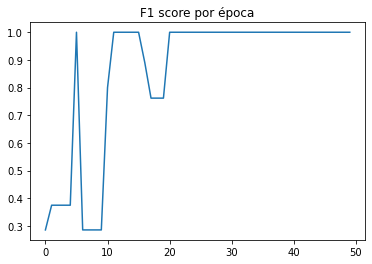

In [120]:
plt.plot(savef1)
_ =plt.title("F1 score por época")

Text(0.5, 1.0, 'Accuracy por época')

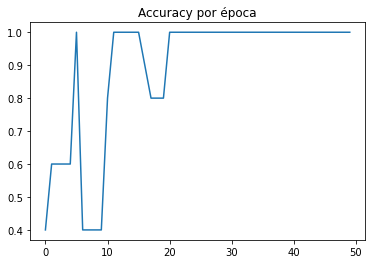

In [119]:
plt.plot(savacc)
_ =plt.title("Accuracy por época")